In [ ]:
!pip install torch pytorch-lightning pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [ ]:
from pytorch_forecasting import TimeSeriesDataSet

In [ ]:
import pandas as pd
import numpy as np

I decided to use the Temporal Fusion Transformer because of it's following interesting characteristics:   
  
*   Multiple time series: We can train a TFT model on thousands of univariate or multivariate time series.
*   Multi-Horizon Forecasting: The model outputs multi-step predictions of one or more target variables — including prediction intervals.
*  Heterogeneous features: TFT supports many types of features, including time-variant known/unknown, time-invariant real/categorical.
* Interpretable predictions: Predictions can be interpreted in terms of variable importance and seasonality.


    
    
    

In [ ]:
B_5min = pd.read_csv('B5M.csv',header=None)

In [ ]:

start = "2004-11-19 09:30:00"
end = "2005-01-27 11:11:00"
index = pd.date_range(start=start, end=end, freq="5T")

The data that was used for this project was internet traffic data collected from UKERNA and represents aggregated traffic in the UK academic network backbone. The units of data bits. It was collected between 19 November 2004 at 09:30 and 27 January 2005 at 11:11. The raw data was recorded at time series intervals of 5 minutes.

In [ ]:
B_5min = B_5min.set_index(index)
B_5min = B_5min.rename(columns = {0:'Traffic'})

In [ ]:
B_5min

Traffic
2004-11-19 09:30:00  1.451600e+15
2004-11-19 09:35:00  1.453550e+15
2004-11-19 09:40:00  1.547400e+15
2004-11-19 09:45:00  1.691360e+15
2004-11-19 09:50:00  1.656210e+15
...                           ...
2005-01-27 10:50:00  1.913330e+15
2005-01-27 10:55:00  1.933310e+15
2005-01-27 11:00:00  1.943330e+15
2005-01-27 11:05:00  1.907330e+15
2005-01-27 11:10:00  1.926330e+15

[19893 rows x 1 columns]

In [ ]:
df = B_5min

In [ ]:
## Will be working with 5min, hours, and days

date = df.index
earliest_time = date.min()

df['hours_from_start'] = (date - earliest_time).seconds // 60 // 60 + (date - earliest_time).days * 24
df['hours_from_start'] = df['hours_from_start'].astype('int')

df['days_from_start'] = (date - earliest_time).days


df['fivemins_from_start'] = ((date - earliest_time).total_seconds() // 60) // 5
df['fivemins_from_start'] = df['fivemins_from_start'].astype('int')

df['hour'] = date.hour
df['day'] = date.day
df['day_of_week'] = date.dayofweek
df['month'] = date.month
df['id'] = 1


For the data pre-processing we take the 5 minute intervals and extract time horizons of hours from the first recorded date time and the days from the start. We also get the hour, day, day of the week, and the month. We also add an id to be able to group all the traffic together. We will be using fivemins from the start as our time series index as it increments increments in steps of one which is needed for the model.
    #Time-varying known
    #Time-varying unknown
    #Time-invariant real
    #Time-invariant categorical


In [ ]:
df

Traffic  hours_from_start  days_from_start  \
2004-11-19 09:30:00  1.451600e+15                 0                0   
2004-11-19 09:35:00  1.453550e+15                 0                0   
2004-11-19 09:40:00  1.547400e+15                 0                0   
2004-11-19 09:45:00  1.691360e+15                 0                0   
2004-11-19 09:50:00  1.656210e+15                 0                0   
...                           ...               ...              ...   
2005-01-27 10:50:00  1.913330e+15              1657               69   
2005-01-27 10:55:00  1.933310e+15              1657               69   
2005-01-27 11:00:00  1.943330e+15              1657               69   
2005-01-27 11:05:00  1.907330e+15              1657               69   
2005-01-27 11:10:00  1.926330e+15              1657               69   

                     fivemins_from_start  hour  day  day_of_week  month  id  
2004-11-19 09:30:00                    0     9   19            4     11   1  
2004-11-19 09:35:00                    1     9   19            4     11   1  
2004-11-19 09:40:00                    2     9   19            4     11   1  
2004-11-19 09:45:00                    3     9   19            4     11   1  
2004-11-19 09:50:00                    4     9   19            4     11   1  
...                                  ...   ...  ...          ...    ...  ..  
2005-01-27 10:50:00                19888    10   27            3      1   1  
2005-01-27 10:55:00                19889    10   27            3      1   1  
2005-01-27 11:00:00                19890    11   27            3      1   1  
2005-01-27 11:05:00                19891    11   27            3      1   1  
2005-01-27 11:10:00                19892    11   27            3      1   1  

[19893 rows x 9 columns]

In [ ]:
max_prediction_length = 48*5 #Predict 4 hours ahead
max_encoder_length = max_prediction_length*6*2 #Use a lookback window of 48 hours

training_cutoff = df["fivemins_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.fivemins_from_start <= training_cutoff],
    time_idx="fivemins_from_start",
    target="Traffic",
    group_ids=['id'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["fivemins_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['Traffic'],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


Here we set up the training and validation data. The prediction length is a 4 hour window ahead and we are also validating on the last 4 hours. We are using a lookback of 48 hours. We are able to use the day, week, month, hour, and unit as time varying features which is one of the unique points of this model. The traffic is a time varying and unknown and is also the target we are trying to predict.

In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

In [ ]:
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
import torch
from pytorch_forecasting import Baseline

In [ ]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).cuda()
baseline_predictions = Baseline().predict(val_dataloader)
MAE_base = (actuals - baseline_predictions).abs().mean().item()
print("Base MAE: ",MAE_base)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO: GPU available: True (cuda), used: True

Base MAE:  909098145021952.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = Trainer(
    max_epochs=45,
    devices=1,
    accelerator='gpu',
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recomm

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Training: 0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: Use

Validation: 0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: Use

Validation: 0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: Use

Validation: 0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: Use

Validation: 0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: Use

Validation: 0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: Use

Validation: 0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: Use

Validation: 0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: Use

Validation: 0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: Use

Validation: 0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: Use

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 20655672131584.000. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 20655672131584.000. Signaling Trainer to stop.


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_2/checkpoints/epoch=9-step=3100.ckpt


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).cuda()
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
#print(actuals)
#print(predictions)
MAE_model = (actuals - predictions).abs().mean().item()
print('Model MAE:',MAE_model)
print('Base MAE:',MAE_base)

#average p50 loss per time series
#print((actuals - predictions).abs().mean(axis=1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/

Model MAE: 50669494992896.0
Base MAE: 909098145021952.0


In [ ]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
#print(raw_predictions)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


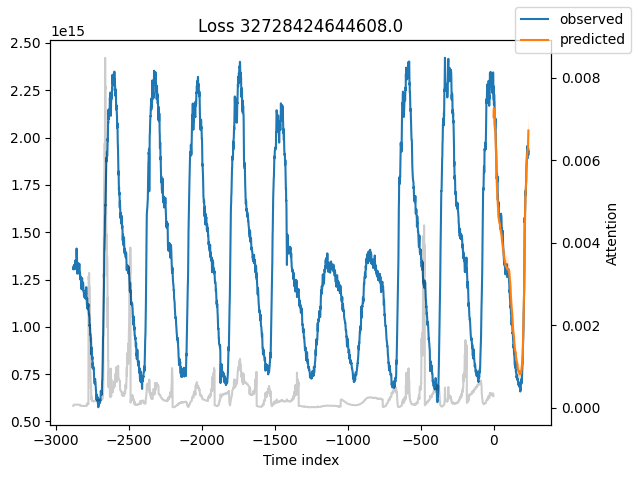

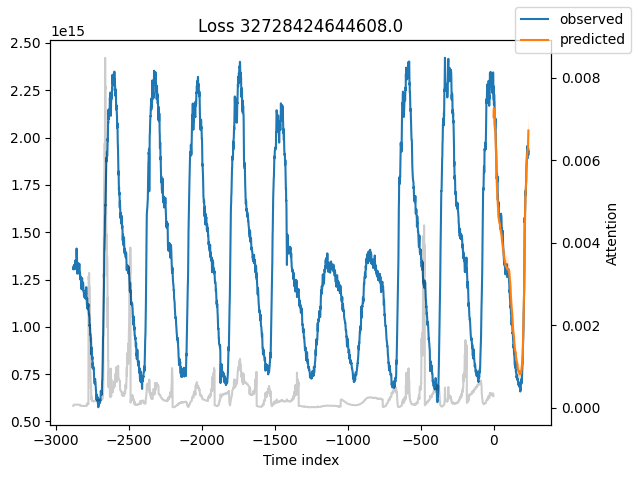

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 4))

best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)

Here we plot the predictions that our model has made on our validation data. The results seem quite impressive.

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x375 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

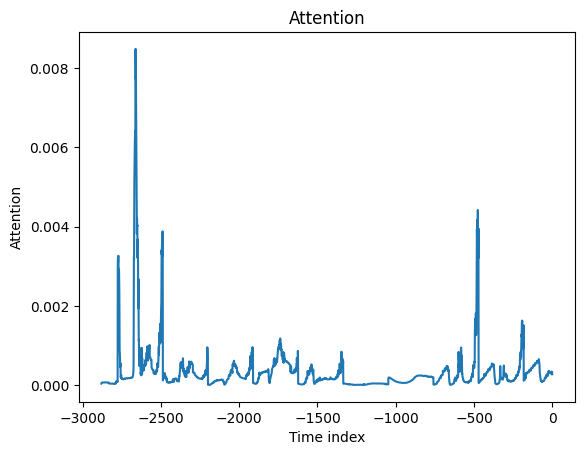

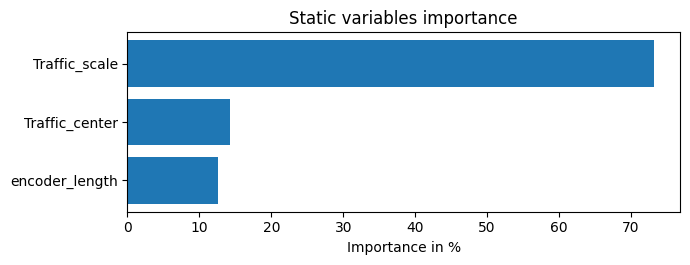

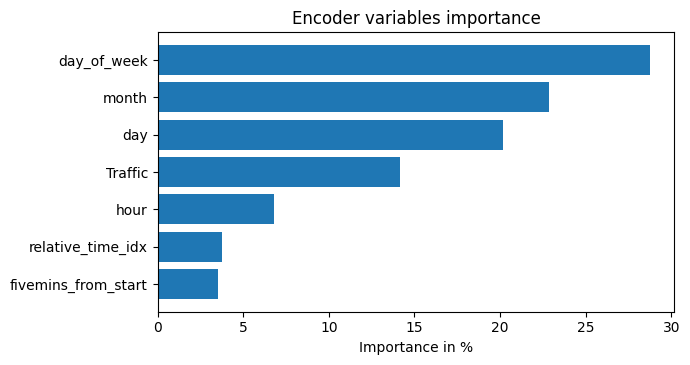

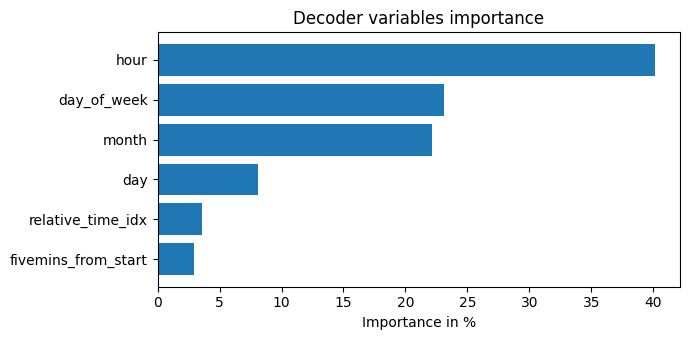

In [ ]:
#Interpreting feature importance
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

Another key strong point of this model is its interpretability. We are able to view which features are most important in calculating past time steps. Obviously the internet traffic is the most important, but we can also see the that the month day and day of week play a part as well. The paper that was used as inspiration for this project comes to similar conclusions when looking at the importance of variables.   

**Additional Considerations**
If I were to continue with this project there are few things I would like to change or consider more in depth. One would be to look at another data set with more variables to take advantage of the TFT's capabiites. Using a multi variate with different groups would be a more interesting problem. Additionally, more tuning of the parameters would probably give better results, but I was still quite impressed with the model. There are also other uses for the model such as being able to detect extreme events. This is something that time series forecasting could be very useful for in an actual production setting.

References:

https://medium.com/towards-data-science/temporal-fusion-transformer-time-series-forecasting-with-deep-learning-complete-tutorial-d32c1e51cd91

https://www.ee.ucl.ac.uk/~mrio/papers/exsy568.pdf

